To build a travel recommendation system with the provided datasets, we can approach it in various ways, focusing on content-based filtering, collaborative filtering, and hybrid models. Below is a step-by-step guide with code to implement these models in a Jupyter Notebook:

# Step 1: Import Libraries and Load Data

We'll start by importing necessary libraries and loading the provided datasets into Pandas DataFrames.


In [28]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
destinations_df = pd.read_csv("Expanded_Destinations.csv")
reviews_df = pd.read_csv("Final_Updated_Expanded_Reviews.csv")
userhistory_df = pd.read_csv("Final_Updated_Expanded_UserHistory.csv")
users_df = pd.read_csv("Final_Updated_Expanded_Users.csv")

In [29]:
destinations_df.head()

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


In [30]:
reviews_df.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


In [31]:
userhistory_df.head()

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


In [32]:
users_df.head()

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


# Step 2: Data Preprocessing 

We will clean and preprocess the data to make it ready for building recommendation models.

In [33]:
# Merge datasets step-by-step
# Step 1: Merge reviews with destinations on 'DestinationID'
reviews_destinations = pd.merge(reviews_df, destinations_df, on='DestinationID', how='inner')

# Step 2: Merge the result with user history on 'UserID'
reviews_destinations_userhistory = pd.merge(reviews_destinations, userhistory_df, on='UserID', how='inner')

# Step 3: Merge the result with users on 'UserID'
df = pd.merge(reviews_destinations_userhistory, users_df, on='UserID', how='inner')

df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,138,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,643,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,454,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,556,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2


In [34]:
df.shape

(993, 20)

In [35]:
df.duplicated().sum()

0

In [36]:
df.isnull().sum()

ReviewID            0
DestinationID_x     0
UserID              0
Rating              0
ReviewText          0
Name_x              0
State               0
Type                0
Popularity          0
BestTimeToVisit     0
HistoryID           0
DestinationID_y     0
VisitDate           0
ExperienceRating    0
Name_y              0
Email               0
Preferences         0
Gender              0
NumberOfAdults      0
NumberOfChildren    0
dtype: int64

# 2.1 Visualization

C:\Users\Noor Saeed\AppData\Local\Temp\ipykernel_6448\3841231242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Popularity', y='Name', data=destinations_df.sort_values(by='Popularity', ascending=False), palette='viridis')


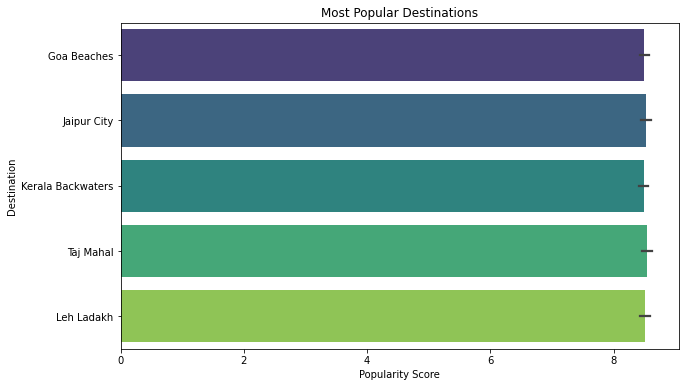

In [37]:
# 1. Destination Popularity
plt.figure(figsize=(10, 6))
sns.barplot(x='Popularity', y='Name', data=destinations_df.sort_values(by='Popularity', ascending=False), palette='viridis')
plt.title('Most Popular Destinations')
plt.xlabel('Popularity Score')
plt.ylabel('Destination')
plt.show()

C:\Users\Noor Saeed\AppData\Local\Temp\ipykernel_6448\3041409595.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type', data=destinations_df, order=destinations_df['Type'].value_counts().index, palette='coolwarm')


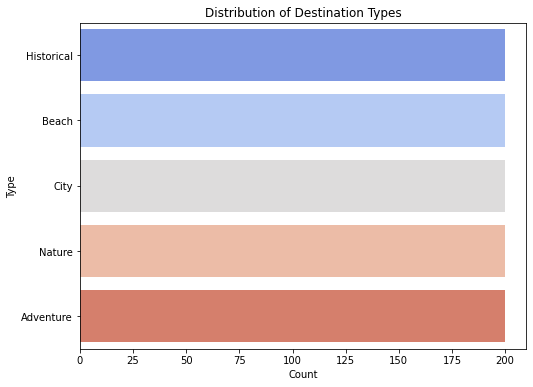

In [38]:
# 2. Destination Types Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='Type', data=destinations_df, order=destinations_df['Type'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Destination Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

C:\Users\Noor Saeed\AppData\Local\Temp\ipykernel_6448\3398856787.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako')


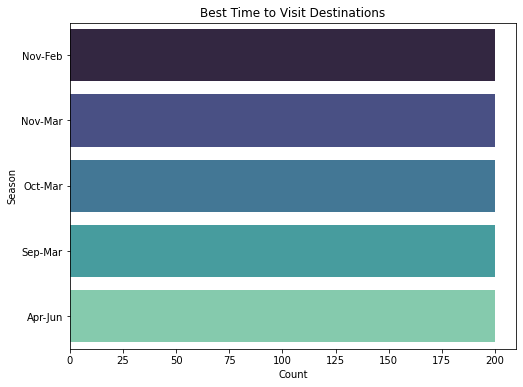

In [39]:
# 3. Best Time to Visit Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako')
plt.title('Best Time to Visit Destinations')
plt.xlabel('Count')
plt.ylabel('Season')
plt.show()

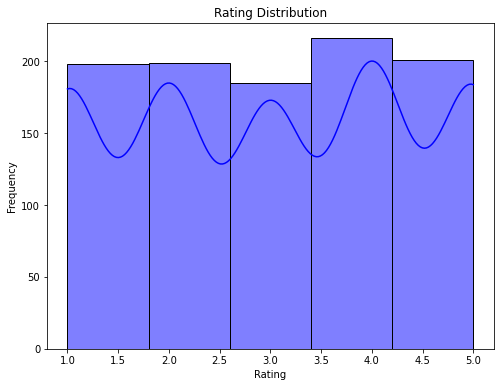

In [40]:
# 4. Ratings Distribution
plt.figure(figsize=(8, 6))
sns.histplot(reviews_df['Rating'], bins=5, kde=True, color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Step 3: Content-Based Recommendation Model

Content-based recommendations recommend destinations based on the attributes of the destination that the user has shown interest in (i.e., based on the "Preferences" and "Type" columns).

### Step 3.1: Prepare the Destination Features
We'll use the "Type", "State", and "BestTimeToVisit" columns to create features for content-based filtering.

In [41]:
# Create a text-based feature for the destinations
df['features'] = df['Type'] + ' ' + df['State'] + ' ' + df['BestTimeToVisit'] + " " + df['Preferences']

# Apply TF-IDF vectorizer to create feature vectors for destinations
vectorizer = TfidfVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(df['features'])

# Compute cosine similarity between destinations
cosine_sim = cosine_similarity(destination_features, destination_features)

### Step 3.2: Recommendation Function 

Based on the cosine similarity matrix, we can recommend destinations similar to the ones the user has liked in the past.

In [42]:
# Define recommendation function
def recommend_destinations(user_id, userhistory_df, destinations_df, cosine_sim):
    """
    Recommends top 5 destinations for a given user based on similarity scores.

    Args:
    - user_id: ID of the user.
    - userhistory_df: User history DataFrame containing 'UserID' and 'DestinationID'.
    - destinations_df: Destinations DataFrame containing destination details.
    - cosine_sim: Cosine similarity matrix for destinations.

    Returns:
    - DataFrame with recommended destinations and their details.
    """
    # Get the destinations the user has visited
    visited_destinations = userhistory_df[userhistory_df['UserID'] == user_id]['DestinationID'].values
    
    # Calculate similarity scores for visited destinations
    similar_scores = np.sum(cosine_sim[visited_destinations - 1], axis=0)
    
    # Recommend the top 5 destinations the user hasn't visited yet
    recommended_destinations_idx = np.argsort(similar_scores)[::-1]
    
    recommendations = []
    for idx in recommended_destinations_idx:
        if destinations_df.iloc[idx]['DestinationID'] not in visited_destinations:
            # Append detailed information for each recommendation
            recommendations.append(destinations_df.iloc[idx][[
                'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
            ]].to_dict())
        if len(recommendations) >= 5:
            break
    
    # Convert recommendations to a DataFrame
    return pd.DataFrame(recommendations)

# Example: Recommend destinations for user with ID 1
recommended_destinations = recommend_destinations(20, userhistory_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,39,Kerala Backwaters,Kerala,Nature,9.276722,Sep-Mar
1,550,Leh Ladakh,Jammu and Kashmir,Adventure,8.747376,Apr-Jun
2,519,Kerala Backwaters,Kerala,Nature,7.772508,Sep-Mar
3,613,Jaipur City,Rajasthan,City,7.893423,Oct-Mar
4,876,Taj Mahal,Uttar Pradesh,Historical,8.796715,Nov-Feb


In [43]:

recommended_destinations = recommend_destinations(1, userhistory_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,99,Kerala Backwaters,Kerala,Nature,8.154277,Sep-Mar
1,81,Taj Mahal,Uttar Pradesh,Historical,8.113730,Nov-Feb
2,69,Kerala Backwaters,Kerala,Nature,9.251450,Sep-Mar
3,165,Leh Ladakh,Jammu and Kashmir,Adventure,7.554650,Apr-Jun
4,481,Taj Mahal,Uttar Pradesh,Historical,8.347502,Nov-Feb


In [44]:
# Example: Recommend destinations for user with ID 1
recommended_destinations = recommend_destinations(40, userhistory_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,662,Goa Beaches,Goa,Beach,7.848867,Nov-Mar
1,201,Taj Mahal,Uttar Pradesh,Historical,7.653509,Nov-Feb
2,926,Taj Mahal,Uttar Pradesh,Historical,8.324742,Nov-Feb
3,927,Goa Beaches,Goa,Beach,7.741214,Nov-Mar
4,202,Goa Beaches,Goa,Beach,8.246719,Nov-Mar


# Step 4: Collaborative Filtering
In collaborative filtering, we recommend destinations based on the behavior and preferences of other similar users.

#### Step 4.1: Create a User-Item Matrix
We'll create a matrix where rows represent users, and columns represent destinations. The values will represent the ratings or experience of the user for each destination.

In [45]:
df.columns

Index(['ReviewID', 'DestinationID_x', 'UserID', 'Rating', 'ReviewText',
       'Name_x', 'State', 'Type', 'Popularity', 'BestTimeToVisit', 'HistoryID',
       'DestinationID_y', 'VisitDate', 'ExperienceRating', 'Name_y', 'Email',
       'Preferences', 'Gender', 'NumberOfAdults', 'NumberOfChildren',
       'features'],
      dtype='object')

In [51]:
# Create a user-item matrix based on user history
user_item_matrix = userhistory_df.pivot(index='UserID', columns='DestinationID', values='ExperienceRating')

# Fill missing values with 0 (indicating no rating/experience)
user_item_matrix.fillna(0, inplace=True)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

### Step 4.2: Cosine Similarity Between Users
We will compute the cosine similarity between users based on the user-item matrix

In [52]:
# Function to recommend destinations based on user similarity
def collaborative_recommend(user_id, user_similarity, user_item_matrix, destinations_df):
    """
    Recommends destinations based on collaborative filtering.

    Args:
    - user_id: ID of the user for whom recommendations are to be made.
    - user_similarity: Cosine similarity matrix for users.
    - user_item_matrix: User-item interaction matrix (e.g., ratings or preferences).
    - destinations_df: DataFrame containing destination details.

    Returns:
    - DataFrame with recommended destinations and their details.
    """
    # Find similar users
    similar_users = user_similarity[user_id - 1]
    
    # Get the top 5 most similar users
    similar_users_idx = np.argsort(similar_users)[::-1][1:6]
    
    # Get the destinations liked by similar users
    similar_user_ratings = user_item_matrix.iloc[similar_users_idx].mean(axis=0)
    
    # Recommend the top 5 destinations
    recommended_destinations_ids = similar_user_ratings.sort_values(ascending=False).head(5).index
    
    # Filter the destinations DataFrame to include detailed information
    recommendations = destinations_df[destinations_df['DestinationID'].isin(recommended_destinations_ids)][[
        'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
    ]]
    
    return recommendations

# Example: Collaborative recommendations for user 1
collaborative_recommendations = collaborative_recommend(15, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
10,11,Taj Mahal,Uttar Pradesh,Historical,8.177709,Nov-Feb
519,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.521876,Apr-Jun
684,685,Leh Ladakh,Jammu and Kashmir,Adventure,7.598827,Apr-Jun
784,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.366933,Apr-Jun
810,811,Taj Mahal,Uttar Pradesh,Historical,9.393806,Nov-Feb


In [53]:
# Example: Collaborative recommendations for user 1
collaborative_recommendations = collaborative_recommend(11, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
5,6,Taj Mahal,Uttar Pradesh,Historical,7.648950,Nov-Feb
367,368,Jaipur City,Rajasthan,City,8.008252,Oct-Mar
519,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.521876,Apr-Jun
784,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.366933,Apr-Jun
969,970,Leh Ladakh,Jammu and Kashmir,Adventure,9.013101,Apr-Jun


In [54]:
# Example: Collaborative recommendations for user 1
collaborative_recommendations = collaborative_recommend(100, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
5,6,Taj Mahal,Uttar Pradesh,Historical,7.648950,Nov-Feb
346,347,Goa Beaches,Goa,Beach,7.920960,Nov-Mar
519,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.521876,Apr-Jun
684,685,Leh Ladakh,Jammu and Kashmir,Adventure,7.598827,Apr-Jun
784,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.366933,Apr-Jun


# Step 6 User input feature base recommendation

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Using regressor for continuous target
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
data = pd.read_csv('final_df.csv')

In [42]:
# Select relevant features
features = ['Name_x', 'State', 'Type', 'BestTimeToVisit', 'Preferences', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
target = 'Popularity'  # Predicting popularity

# Encode categorical variables
label_encoders = {}
for col in features:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# Split the dataset
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Mean Squared Error: 0.30
R² Score: 0.07


In [45]:
import pandas as pd

# Prediction system
def recommend_destinations(user_input, model, label_encoders, features, data):
    # Encode user input
    encoded_input = {}
    for feature in features:
        if feature in label_encoders:
            encoded_input[feature] = label_encoders[feature].transform([user_input[feature]])[0]
        else:
            encoded_input[feature] = user_input[feature]

    # Convert to DataFrame
    input_df = pd.DataFrame([encoded_input])

    # Predict popularity
    predicted_popularity = model.predict(input_df)[0]

    return predicted_popularity


# Example user input
user_input = {
    'Name_x': 'Jaipur City',
    'Type': 'City',
    'State': 'Rajasthan',
    'BestTimeToVisit': 'Oct-Mar',  # This might be an unseen label
    'Preferences': 'City, Historical',
    'Gender': 'Female',
    'NumberOfAdults': 2,
    'NumberOfChildren': 1,
}

# Make a prediction
predicted_popularity = recommend_destinations(user_input, model, label_encoders, features, data)

# Print the predicted popularity and the recommended destination details
print(f"Predicted Popularity Score: {predicted_popularity:.2f}")

Predicted Popularity Score: 7.88


In [46]:
import pickle

pickle.dump(model, open("model.pkl",'wb'))
pickle.dump(label_encoders, open("label_encoders.pkl",'wb'))